In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle

In [2]:
train_dataset=datasets.MNIST(root='./data',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_dataset=datasets.MNIST(root='./data',
                          train=False,
                          download=True,
                          transform=transforms.ToTensor())

In [3]:
batch_size=100
n_iters=3000
num_epochs=int(n_iters*batch_size/len(train_dataset))
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,
                                        batch_size=batch_size,
                                        shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,
                                       batch_size=batch_size,
                                       shuffle=False)

In [4]:
class FeedForwardNN(nn.Module):
    def __init__(self,input_size,hidden_size,num_classes):
        super(FeedForwardNN,self).__init__()
        self.fc1=nn.Linear(input_size,hidden_size)
        self.relu=nn.ReLU()
        self.fc2=nn.Linear(hidden_size,num_classes)
        
    def forward(self,x):
        out=self.fc1(x)
        out=self.relu(out)
        out=self.fc2(out)
        return out

In [5]:
input_size=28*28
hidden_size=512
num_classes=10
learning_rate=0.01
model=FeedForwardNN(input_size,hidden_size,num_classes)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)

In [6]:
device=('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda:0


FeedForwardNN(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [7]:
iter=0
for epoch in range(num_epochs):
    for i,(images,labels) in enumerate(train_loader):
        images, labels=images.to(device),labels.to(device)
        images=images.view(-1,28*28)
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        iter+=1
        if iter % 500 ==0:
            correct=0
            total=0
            for images,labels in test_loader:
                images,labels=images.to(device), labels.to(device)
                images=images.view(-1,28*28)
                outputs=model(images)
                _,predictions=torch.max(outputs,1)
                total+=images.size()[0]
                correct+=(predictions==labels).sum()
                accuracy=float(100*correct)/total
                
                
            print('Loss ', loss.item(), 'Iteration ',
                  iter, ' Accuracy ', accuracy)

Loss  1.012006402015686 Iteration  500  Accuracy  82.94
Loss  0.5077894330024719 Iteration  1000  Accuracy  87.32
Loss  0.47613775730133057 Iteration  1500  Accuracy  88.93
Loss  0.4306364357471466 Iteration  2000  Accuracy  89.61
Loss  0.31300032138824463 Iteration  2500  Accuracy  90.26
Loss  0.31958597898483276 Iteration  3000  Accuracy  90.69


In [8]:
images_all=list()
adv_all=list()
correct=0
total=0
for images,labels in test_loader:
    images, labels=images.to(device),labels.to(device)
    images=images.view(-1,28*28)
    images.requires_grad_()
    optimizer.zero_grad()
    outputs=model(images)
    loss=criterion(outputs,labels)
    
    
    loss.backward()
    _,predictions=torch.max(outputs,1)
    #FGSM
    epsilon=0.1
    x_grad=torch.sign(images.grad)
    x_adversarial=torch.clamp(images.detach()+epsilon*x_grad,0,1)
    
    _,adversarial_pred=torch.max(model(x_adversarial),1)
    images_all.append([images.view(-1,28,28).detach().cpu().numpy(),labels])
    adv_all.append([x_adversarial.view(-1,28,28).cpu().numpy(),adversarial_pred])

    correct+=(predictions==adversarial_pred).sum()
    total+=len(predictions)
print("Error Rate is ",float(total-correct)*100/total)

Error Rate is  48.32


In [9]:
curr,label=images_all[0]
currad,labelad=adv_all[0]
print(type(curr),type(label))

<class 'numpy.ndarray'> <class 'torch.Tensor'>


Original Label  7  Adv Label  7


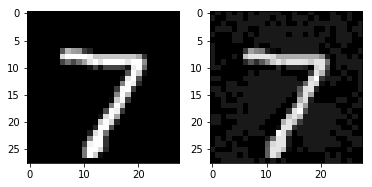

Original Label  2  Adv Label  6


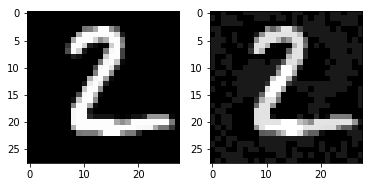

Original Label  1  Adv Label  2


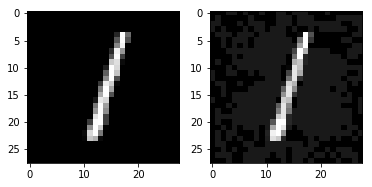

Original Label  0  Adv Label  0


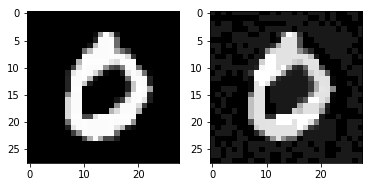

Original Label  4  Adv Label  9


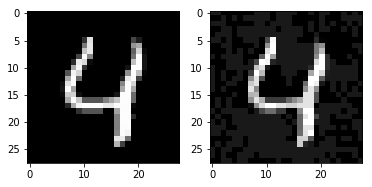

Original Label  1  Adv Label  1


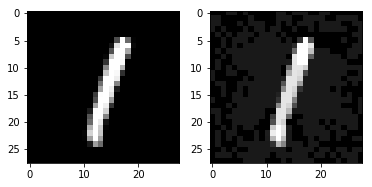

Original Label  4  Adv Label  5


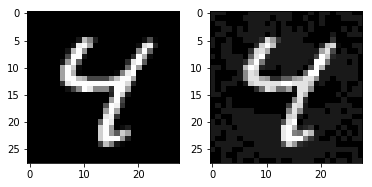

Original Label  9  Adv Label  5


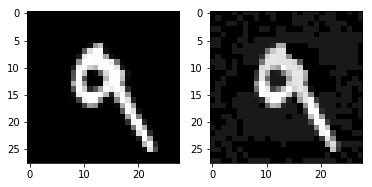

Original Label  5  Adv Label  6


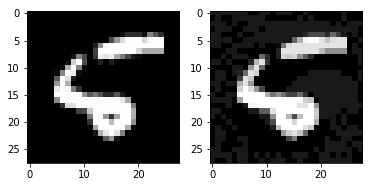

Original Label  9  Adv Label  7


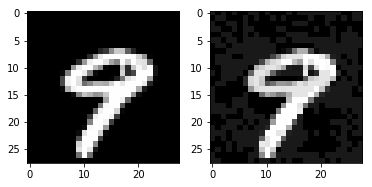

Batch Error rate  65.0


In [10]:
for a in range(10):
    plt.figure()
    plt.subplot(121)
    plt.imshow(curr[a],cmap='gray')
    plt.subplot(122)
    plt.imshow(currad[a],cmap='gray')
    print("Original Label ", label[a].cpu().numpy(), " Adv Label ",labelad[a].cpu().numpy())
    plt.show()
total=batch_size
correct=(label==labelad).sum()
print("Batch Error rate ",float(total-correct)*100/total)

# Church Window Plots 
Proposed in
Warde-Farley, David, and Ian Goodfellow. "11 adversarial perturbations of deep neural networks." Perturbations, Optimization, and Statistics (2016): 311.

In [11]:
#Finds the Ortonormal vector of a given input
def ort_torch(x):
    vert=torch.randn(x.shape).to(device)
    vert-=torch.mul(vert,x)*x
    vert/=torch.norm(vert)
    return vert

In [12]:
#Definining color for each class
colors = [[134, 24, 194], # 0 --> purple to pink intense
 [ 44 ,170, 223], # 1 --> medium to light blue
 [247 , 45 ,186], # 2 --> intense darker barbie pink
 [139, 195 , 58], # 3 --> medium lime green
 [ 49 , 59 , 55], # 4 --> dark grey
 [ 83, 102  ,98], # 5 --> light grey
 [219 , 17 , 59], # 6 --> intense pinkish red
 [116 , 56 ,240], # 7 --> cold intense purple to blue
 [155 , 32,  81], # 8 --> dark rose
 [ 21 , 40, 213]] # 9 --> intense royal blue

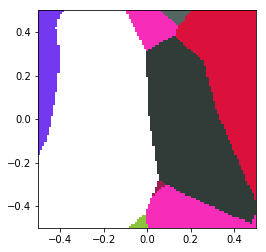

In [19]:
res=101
window=0.5
x=np.linspace(-window,window,res)
y=np.linspace(-window,window,res)
out=np.zeros([res,res,3],dtype=np.uint8)
#print(x)
data_loader=torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                       shuffle=True)
for image,label in data_loader:
    image,label=image.to(device),label.to(device)
    image=image.view(-1,input_size)
    image.requires_grad_()
    output=model(image)
    _,prediction=torch.max(output,1)
    
    loss=criterion(output,label)
    loss.backward()
    adv_direction=image.grad
    adv_normal=ort_torch(adv_direction)
    adv_direction=torch.sign(adv_direction)
    adv_normal=torch.sign(adv_normal)
    
    for a in range(y.size):
        for b in range(x.size):
            update=y[a]*adv_normal+x[b]*adv_direction
            update=update.to(device)
            image_adv=torch.clamp(image.detach()+update,0,1)
            _,adv_out=torch.max(model(image_adv),1)
            if(adv_out==label):
                out[a][b]=[255,255,255]
            else:
                out[a][b]=colors[adv_out]
    

    break
plt.imshow(out,extent=[-window,window,-window,window])